In [52]:
#importazione del df
import pandas as pd
df = pd.read_csv('csv/decessi_tot.csv')
df.head()

,Data,Totale
0,2015-01-01,151
1,2015-01-02,160
2,2015-01-03,145
3,2015-01-04,153
4,2015-01-05,171


In [53]:
#trasformo le date e i numeri
df.Data = pd.to_datetime(df.Data, dayfirst=True)
df.Totale = pd.to_numeric(df.Totale)
df.head()

,Data,Totale
0,2015-01-01,151
1,2015-01-02,160
2,2015-01-03,145
3,2015-01-04,153
4,2015-01-05,171


In [54]:
#metto il campo 'Data' come indice
df=df.set_index('Data')
df.head()

,Totale
Data,
2015-01-01,151
2015-01-02,160
2015-01-03,145
2015-01-04,153
2015-01-05,171


In [55]:
#creo la time series
ts = df.Totale
ts.tail()

Data
2020-04-26    125
2020-04-27    141
2020-04-28    126
2020-04-29    116
2020-04-30    103
Name: Totale, dtype: int64

In [56]:
from datetime import datetime
from datetime import timedelta
start_date = datetime(2015,1,1)
end_date = datetime(2020,4,30)
lim_ts = ts[start_date:end_date]

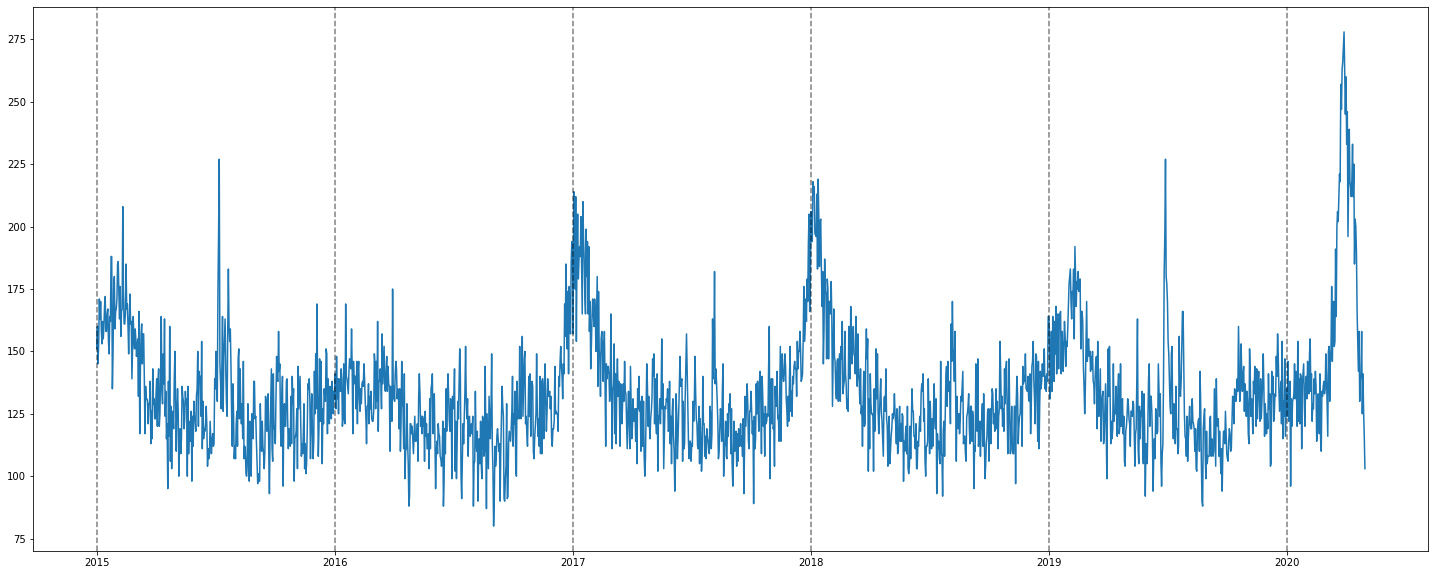

In [57]:
#visulizzo il grafico della time series
import matplotlib.pyplot as plt
plt.figure(figsize=(25,10))
plt.plot(lim_ts)
for year in range(start_date.year,end_date.year+1):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.5)

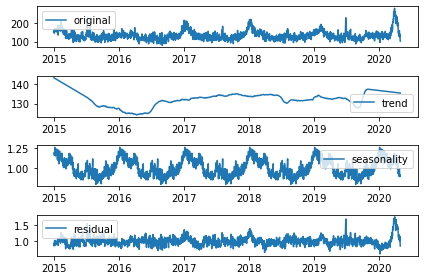

In [58]:
#decomposizione della serie in trend, stagionalità e residui
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(ts, period=365, two_sided=True, extrapolate_trend=1, model='multiplicative')

ts_trend = decomposition.trend #andamento della curva
ts_seasonal = decomposition.seasonal #stagionalità 
ts_residual = decomposition.resid #parti rimanenti
plt.subplot(411)
plt.plot(ts,label='original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(ts_trend,label='trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(ts_seasonal,label='seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(ts_residual,label='residual')
plt.legend(loc='best')
plt.tight_layout()

In [59]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=365).mean()
    rolstd = timeseries.rolling(window=365).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    
    critical_value = dftest[4]['5%']
    test_statistic = dftest[0]
    alpha = 1e-3
    pvalue = dftest[1]
    if pvalue < alpha and test_statistic < critical_value:  # null hypothesis: x is non stationary
        print("X is stationary")
    else:
        print("X is not stationary")

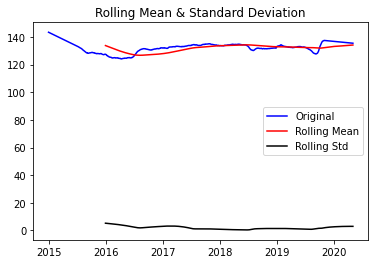

Results of Dickey-Fuller Test:
Test Statistic                   -3.114611
p-value                           0.025491
#Lags Used                        9.000000
Number of Observations Used    1937.000000
Critical Value (1%)              -3.433730
Critical Value (5%)              -2.863033
Critical Value (10%)             -2.567565
dtype: float64
X is not stationary


In [60]:
#verifico che il trend sia stazionario
test_stationarity(ts_trend.dropna())

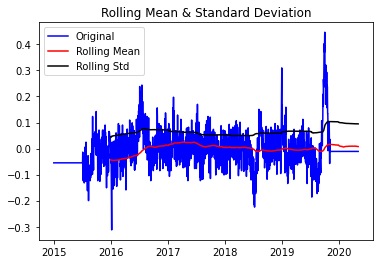

Results of Dickey-Fuller Test:
Test Statistic                -5.718177e+00
p-value                        7.041233e-07
#Lags Used                     8.000000e+00
Number of Observations Used    1.937000e+03
Critical Value (1%)           -3.433730e+00
Critical Value (5%)           -2.863033e+00
Critical Value (10%)          -2.567565e+00
dtype: float64
X is stationary


In [61]:
#rendo il trend stazionario con l'operazione di differenzazione
ts_trend_diff = ts_trend.diff()
test_stationarity(ts_trend_diff.dropna())

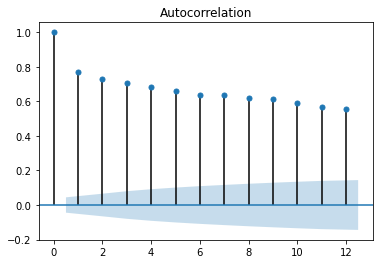

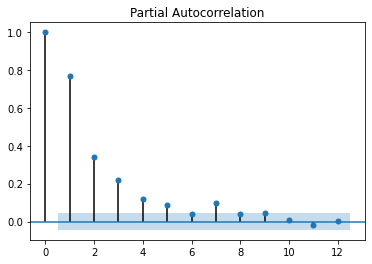

In [62]:
#grafici di autocorrelazione e autocorrelazione parziale
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(ts, lags =12)
plot_pacf(ts, lags =12)
plt.show()

In [63]:
#suddivisione del trend della serie in train e test
from datetime import datetime
train_end = datetime(2019,10,31)
test_end = datetime (2019,12,31)
covid_end = datetime(2020,4,30)

train = ts_trend[:train_end]
test = ts_trend[train_end + timedelta(days=1): test_end]

#trend COVID?
trend_covid = ts_trend[test_end + timedelta(days=1): covid_end]

#print(len(train))
#print(len(test))
#ts_trend
#print(len(covid))


In [64]:
#creazione del modello
from statsmodels.tsa.statespace.sarimax import SARIMAX

p = 8
d = 1
q = 12

model = SARIMAX(train, order=(p, d, q))
model_fit = model.fit(disp=1,solver='powell')
print(model_fit.summary())

c:\users\monta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
c:\users\monta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
c:\users\monta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


                               SARIMAX Results                                
Dep. Variable:                  trend   No. Observations:                 1765
Model:              SARIMAX(8, 1, 12)   Log Likelihood                2798.327
Date:                Sun, 19 Jul 2020   AIC                          -5554.654
Time:                        17:45:47   BIC                          -5439.672
Sample:                    01-01-2015   HQIC                         -5512.166
                         - 10-31-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1219      0.393     -0.310      0.756      -0.892       0.648
ar.L2          0.3049      0.420      0.727      0.468      -0.518       1.127
ar.L3          0.5756      0.361      1.597      0.1

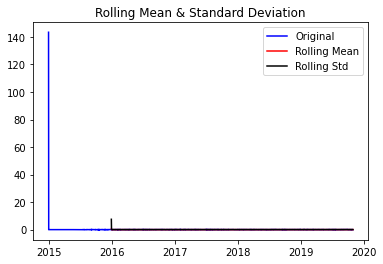

Results of Dickey-Fuller Test:
Test Statistic                -2896.787897
p-value                           0.000000
#Lags Used                        0.000000
Number of Observations Used    1764.000000
Critical Value (1%)              -3.434062
Critical Value (5%)              -2.863180
Critical Value (10%)             -2.567643
dtype: float64
X is stationary


In [65]:
#verifico che i residui della serie siano stazionari
residuals = model_fit.resid
test_stationarity(residuals)

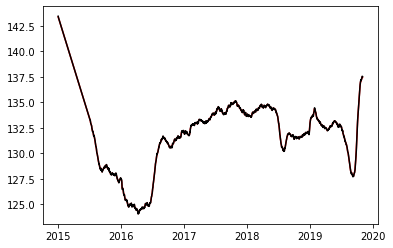

In [66]:
#verifico che il risultato del modello sul train
plt.plot(train.iloc[1:], color='red')
plt.plot(model_fit.fittedvalues.iloc[1:],color='black')
plt.show()

In [67]:
model_fit.fittedvalues #valori del modello 

Data
2015-01-01      0.000000
2015-01-02    143.435617
2015-01-03    143.344151
2015-01-04    143.283223
2015-01-05    143.225848
                 ...    
2019-10-27    137.403919
2019-10-28    137.433970
2019-10-29    137.552744
2019-10-30    137.545323
2019-10-31    137.523605
Length: 1765, dtype: float64

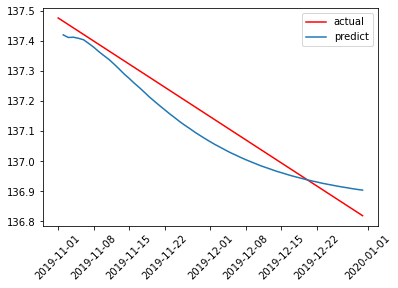

In [68]:
# predizioni sul test set
predictions = model_fit.forecast(steps=len(test))
plt.plot(test, color='red', label='actual')
plt.plot(predictions.iloc[1:], label='predict')
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [69]:
#calcolo RMSE
import numpy as np
from statsmodels.tools.eval_measures import rmse
nrmse = rmse(predictions, test)/(np.max(test)-np.min(test))
print('RMSE = ', nrmse)

RMSE =  0.08590881945741215


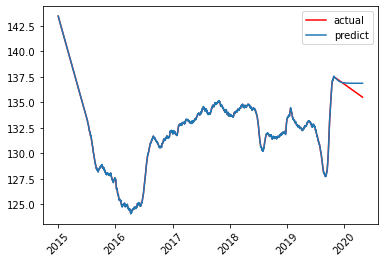

In [70]:
# predizione sul trend della serie storica includendo il 2020
predictions_trend = model_fit.predict(start=0, end=len(ts_trend.iloc[:-1]))
plt.plot(ts_trend, color='red', label='actual')
plt.plot(predictions_trend.iloc[1:], label='predict')
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [71]:
ts_trend

Data
2015-01-01    143.435616
2015-01-02    143.380822
2015-01-03    143.326027
2015-01-04    143.271233
2015-01-05    143.216438
                 ...    
2020-04-26    135.536986
2020-04-27    135.526027
2020-04-28    135.515068
2020-04-29    135.504110
2020-04-30    135.493151
Name: trend, Length: 1947, dtype: float64

In [72]:
covid_predictions = predictions_trend.iloc[1826:] #valori della previsione del periodo covid (dal 01-01-2020 al 30-04-2020)

In [73]:
covid_predictions

2020-01-01    136.901589
2020-01-02    136.899383
2020-01-03    136.897517
2020-01-04    136.895324
2020-01-05    136.893354
                 ...    
2020-04-26    136.856678
2020-04-27    136.856676
2020-04-28    136.856559
2020-04-29    136.856647
2020-04-30    136.856668
Freq: D, Length: 121, dtype: float64

In [74]:
trend_covid

Data
2020-01-01    136.808219
2020-01-02    136.797260
2020-01-03    136.786301
2020-01-04    136.775342
2020-01-05    136.764384
                 ...    
2020-04-26    135.536986
2020-04-27    135.526027
2020-04-28    135.515068
2020-04-29    135.504110
2020-04-30    135.493151
Name: trend, Length: 121, dtype: float64

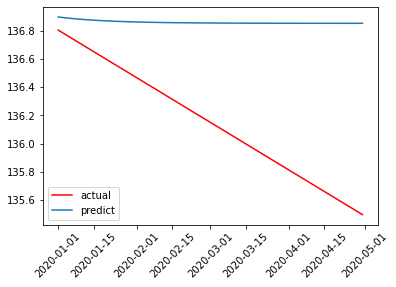

In [75]:
plt.plot(trend_covid, label='actual', color='red')
plt.plot(covid_predictions, label='predict')
plt.xticks(rotation=45)
plt.legend()
plt.show()

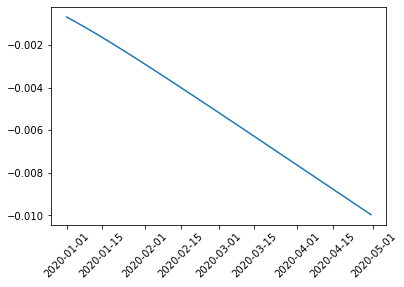

In [76]:
#calcolo della differenza tra i valori reali del covid e la previsione (periodo di riferimento 01-01-2020 - 30-04-2020)
trend_covid_diff = (trend_covid - covid_predictions) / covid_predictions
trend_covid = trend_covid_diff.dropna()
plt.plot(trend_covid_diff)
plt.xticks(rotation=45)
plt.show()

In [77]:
trend_covid_diff #differenza tra i valori del trend_covid e la previsione

Data
2020-01-01   -0.000682
2020-01-02   -0.000746
2020-01-03   -0.000812
2020-01-04   -0.000876
2020-01-05   -0.000942
                ...   
2020-04-26   -0.009643
2020-04-27   -0.009723
2020-04-28   -0.009802
2020-04-29   -0.009883
2020-04-30   -0.009963
Length: 121, dtype: float64

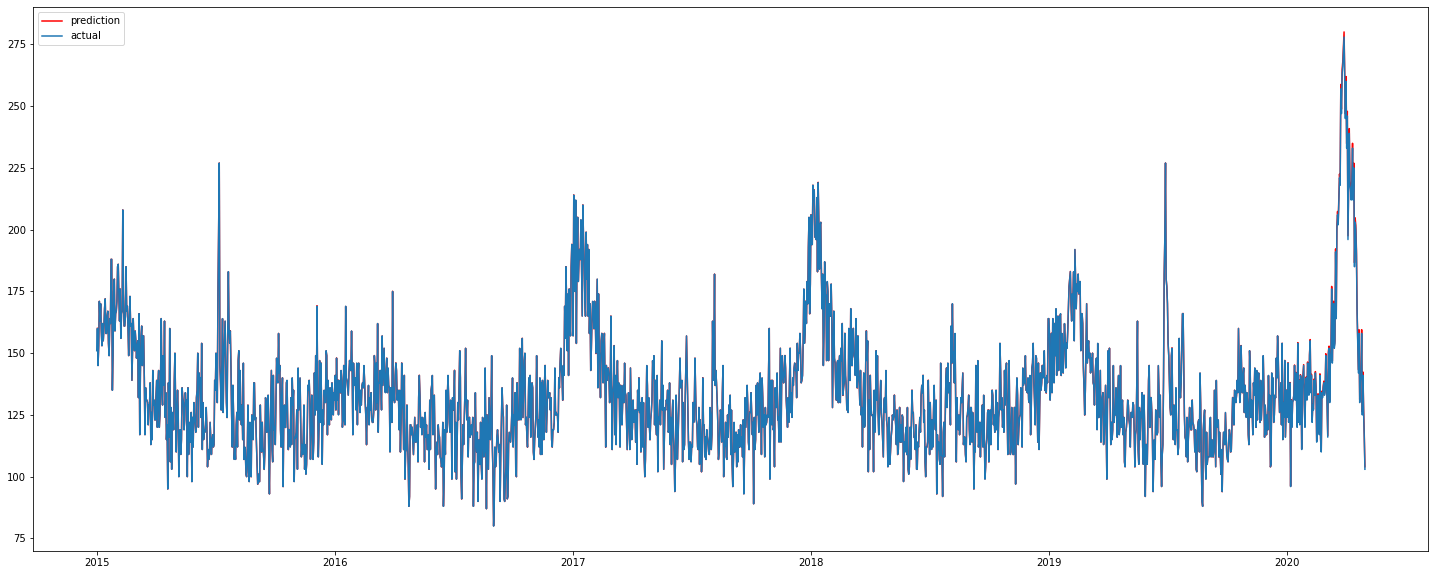

In [81]:
predictions_tot = predictions_trend.iloc[1:] * ts_seasonal * ts_residual
plt.figure(figsize=(25,10))
plt.plot(predictions_tot, color='red', label='prediction')
plt.plot(ts, label='actual')
plt.legend()
plt.show()

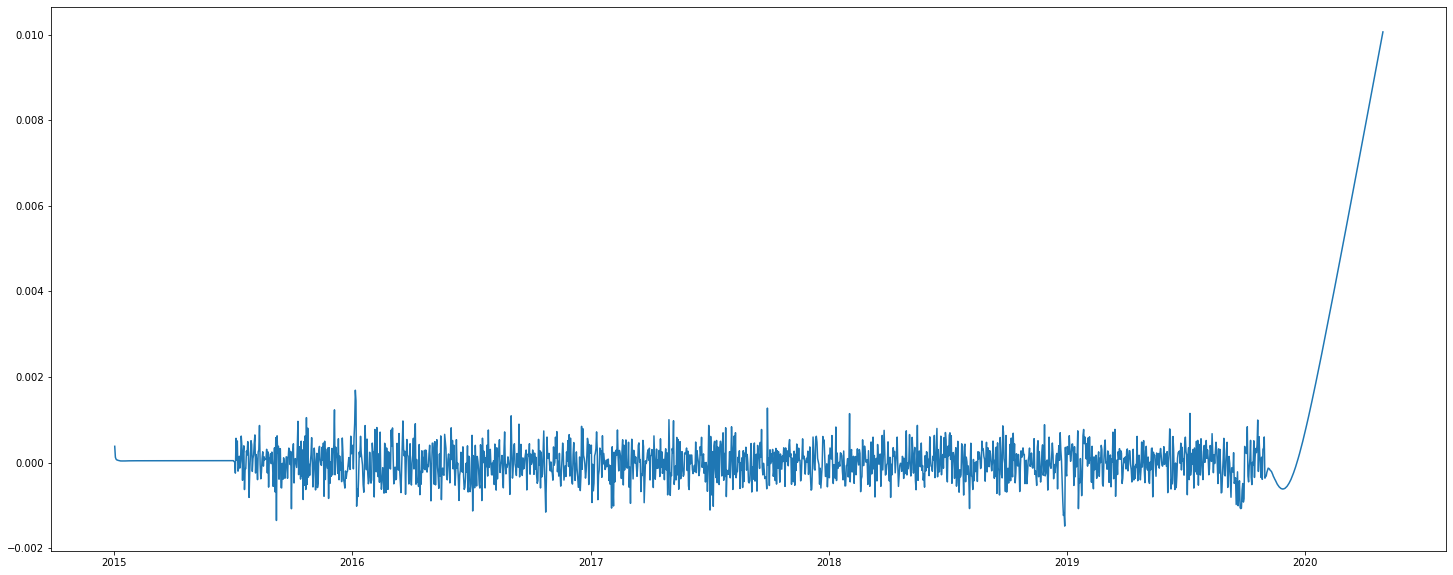

In [82]:
diff_predictions_tot = (predictions_tot - ts) / ts
plt.figure(figsize=(25,10))
plt.plot(diff_predictions_tot)
plt.show()